In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
import warnings
warnings.filterwarnings('ignore')
from category_encoders import TargetEncoder
from scipy.stats import norm
import geopandas as gpd

# Data Importing

In [2]:
# Loading monthly transaction data
transactions_month_6 = pd.read_csv('data/transactions_month_6.csv')
transactions_month_7 = pd.read_csv('data/transactions_month_7.csv')
transactions_month_8 = pd.read_csv('data/transactions_month_8.csv')
transactions_month_9 = pd.read_csv('data/transactions_month_9.csv')
transactions_month_10 = pd.read_csv('data/transactions_month_10.csv')
transactions_month_11 = pd.read_csv('data/transactions_month_11.csv')
transactions_month_12 = pd.read_csv('data/transactions_month_12.csv')
fraud = pd.read_csv('data/fraud.csv')

# Concatenating them into a single DataFrame
all_transactions = [transactions_month_6, transactions_month_7, transactions_month_8,
                    transactions_month_9, transactions_month_10, transactions_month_11,
                    transactions_month_12]

merged_transactions = pd.concat(all_transactions, ignore_index=True)

# Merging with fraud labels using 'trans_id'
merged_data = pd.merge(merged_transactions, fraud, on='trans_id', how='left')
print("Merged DataFrame shape:", merged_data.shape)
merged_data.head()

Merged DataFrame shape: (555719, 23)


,trans_id,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2020-06-21 12:14:00,2.291160e+15,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,Male,351 Darlene Green,...,33.9659,-80.9355,333497,Mechanical engineer,19/03/1968,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,1,2020-06-21 12:14:00,3.573030e+15,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,Female,3638 Marsh Union,...,40.3207,-110.4360,302,"Sales professional, IT",17/01/1990,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2,2020-06-21 12:14:00,3.598220e+15,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,Female,9333 Valentine Point,...,40.6729,-73.5365,34496,"Librarian, public",21/10/1970,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,3,2020-06-21 12:15:00,3.591920e+15,fraud_Haley Group,misc_pos,60.05,Brian,Williams,Male,32941 Krystal Mill Apt. 552,...,28.5697,-80.8191,54767,Set designer,25/07/1987,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,4,2020-06-21 12:15:00,3.526830e+15,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,Male,5783 Evan Roads Apt. 465,...,44.2529,-85.0170,1126,Furniture designer,06/07/1955,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


# Data Cleaning

In [3]:
# Removing duplicates
initial_shape = merged_data.shape
df = merged_data.drop_duplicates()
print(f"Removed {initial_shape[0] - df.shape[0]} duplicate rows. New shape: {df.shape}")

Removed 0 duplicate rows. New shape: (555719, 23)


In [4]:
# Checking for missing values in the DataFrame
df.isnull().sum()

trans_id                  0
trans_date_trans_time     0
cc_num                    0
merchant                  9
category                  6
amt                       0
first                     0
last                     21
gender                    0
street                   14
city                      0
state                     0
zip                       0
lat                       0
long                      0
city_pop                  0
job                      17
dob                       0
trans_num                28
unix_time                 0
merch_lat                 0
merch_long                0
is_fraud                  0
dtype: int64

In [5]:
# Dropping rows with missing values, resetting the index, 
# and verifying that no null values remain while checking the updated DataFrame shape.
df = df.dropna()
df = df.reset_index(drop=True)

print(df.isnull().sum())
print(df.shape)

trans_id                 0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64
(555624, 23)


In [6]:
# Counting the number of unique values in each column of the DataFrame.
df.nunique()

trans_id                 555624
trans_date_trans_time    226966
cc_num                      904
merchant                    693
category                     14
amt                       37252
first                       341
last                        471
gender                        2
street                      924
city                        849
state                        96
zip                         912
lat                         910
long                        910
city_pop                    835
job                         478
dob                         910
trans_num                555624
unix_time                544672
merch_lat                546397
merch_long               551676
is_fraud                      2
dtype: int64

In [7]:
# Displaying the frequency of each unique state in the 'state' column
df["state"].value_counts()
print(df["state"].nunique())

96


In [8]:
# Since the 96 states is impossible, we find some lower cases of the states

In [9]:
# Converting state names to uppercase
df["state"] = df["state"].str.upper()
print(df["state"].nunique())

50


In [10]:
# Standardizing gender values by replacing "Male" with "M" and "Female" with "F".
df["gender"] = df["gender"].replace({"Male": "M", "Female": "F"})

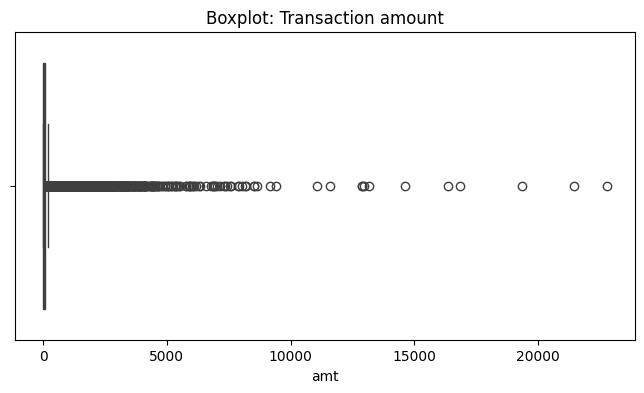

In [11]:
# Creating a boxplot to visualize the distribution of transaction amounts and detect potential outliers.
plt.figure(figsize=(8,4))
sns.boxplot(x=df['amt'])
plt.title("Boxplot: Transaction amount")
plt.show()

In [12]:
# Calculating the interquartile range (IQR) using the 15th and 85th percentiles 
# and determining the lower and upper bounds for outlier detection.

Q1 = df['amt'].quantile(0.15)
Q3 = df['amt'].quantile(0.85)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print("Lower Bound:", lower_bound)
print("Upper Bound:", upper_bound)

Lower Bound: -150.79999999999998
Upper Bound: 266.96


In [13]:
# Check the shape of data frame again after cleaning
df.shape

(555624, 23)

In [14]:
df.to_csv('fraud_transaction_data(after cleaning).csv', index=False)

# Exploratory Data Analysis (EDA)

In [15]:
# Summary Statistics
print("Summary statistics for numerical columns:")
print(df.describe())

Summary statistics for numerical columns:
            trans_id        cc_num            amt            zip  \
count  555624.000000  5.556240e+05  555624.000000  555624.000000   
mean   277858.232708  4.178524e+17      69.391458   48842.008909   
std    160422.412781  1.309856e+18     156.750781   26855.058288   
min         0.000000  6.041621e+10       1.000000    1257.000000   
25%    138927.750000  1.800430e+14       9.630000   26292.000000   
50%    277861.500000  3.521420e+15      47.300000   48174.000000   
75%    416788.250000  4.635330e+15      83.010000   72011.000000   
max    555718.000000  4.992350e+18   22768.110000   99921.000000   

                 lat           long      city_pop     unix_time  \
count  555624.000000  555624.000000  5.556240e+05  5.556240e+05   
mean       38.543284     -90.231148  8.822309e+04  1.380679e+09   
std         5.061386      13.721755  3.003930e+05  5.201112e+06   
min        20.027100    -165.672300  2.300000e+01  1.371817e+09   
25%       

In [16]:
# Displaying the distribution of fraud and non-fraud transactions as proportions of the total dataset.
print('Distribution of the Classes in the subsample dataset')
print(df['is_fraud'].value_counts()/len(df))

Distribution of the Classes in the subsample dataset
is_fraud
0    0.996141
1    0.003859
Name: count, dtype: float64


In [17]:
# Identifying job categories with unusually 
# high or low fraud cases using the IQR method for outlier detection.
job_counts = df[df["is_fraud"] == 1]["job"].value_counts()

Q1 = job_counts.quantile(0.25)
Q3 = job_counts.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outlier_jobs = job_counts[(job_counts < lower_bound) | (job_counts > upper_bound)]

print("Outlier Jobs in Fraud Cases:")
print(outlier_jobs)

Outlier Jobs in Fraud Cases:
job
Science writer                            30
Licensed conveyancer                      29
Systems developer                         29
Engineer, biomedical                      28
Colour technologist                       27
Therapist, occupational                   27
Comptroller                               26
Counsellor                                26
Research scientist (physical sciences)    25
Commissioning editor                      24
Chemical engineer                         23
Research officer, trade union             23
Sub                                       22
Name: count, dtype: int64


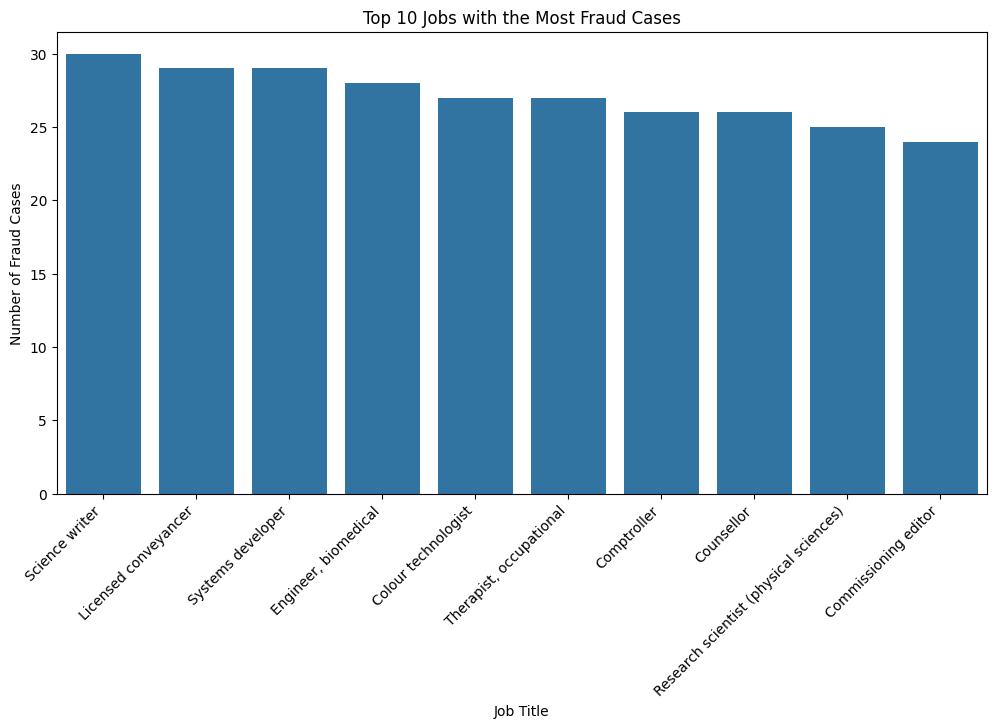

In [18]:
# Visualizing the top 10 job titles associated with the most fraud cases using a bar plot.
top_jobs = df[df["is_fraud"] == 1]["job"].value_counts().nlargest(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_jobs.index, y=top_jobs.values)

plt.xlabel("Job Title")
plt.ylabel("Number of Fraud Cases")
plt.title("Top 10 Jobs with the Most Fraud Cases")
plt.xticks(rotation=45, ha="right")

plt.show()

In [19]:
# Identifying cities with significantly 
# high or low fraud cases using the IQR method for outlier detection.
city_counts = df[df["is_fraud"] == 1]["city"].value_counts()

Q1 = city_counts.quantile(0.25)
Q3 = city_counts.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outlier_cities = city_counts[(city_counts < lower_bound) | (city_counts > upper_bound)]

print("Outlier Cities in Fraud Cases:")
print(outlier_cities)

Outlier Cities in Fraud Cases:
city
Camden        27
Birmingham    25
Burrton       19
Name: count, dtype: int64


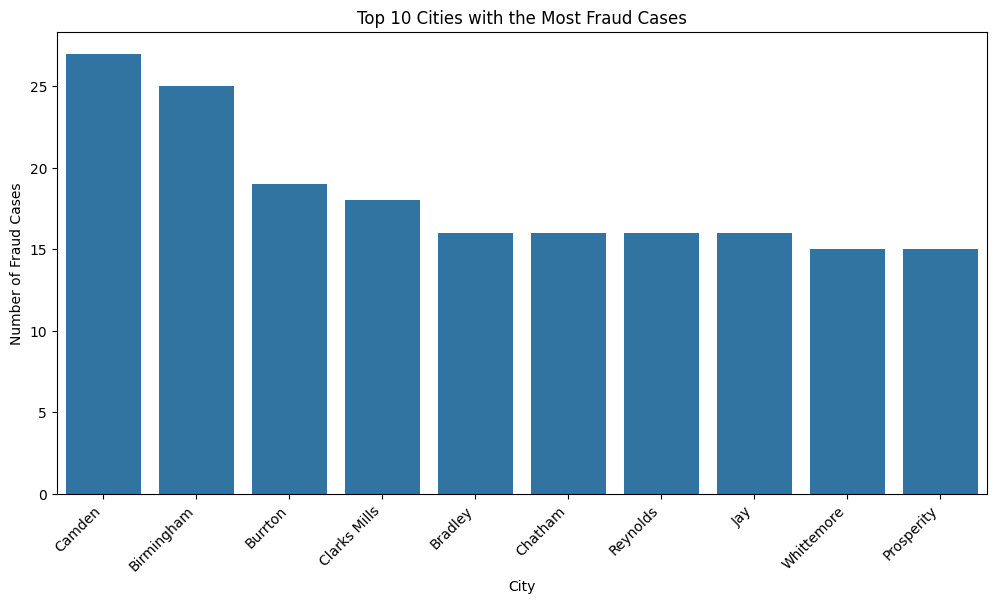

In [20]:
# Visualizing the top 10 cities with the highest number of fraud cases using a bar plot.
top_cities = city_counts.nlargest(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_cities.index, y=top_cities.values)

plt.xlabel("City")
plt.ylabel("Number of Fraud Cases")
plt.title("Top 10 Cities with the Most Fraud Cases")
plt.xticks(rotation=45, ha="right")

plt.show()

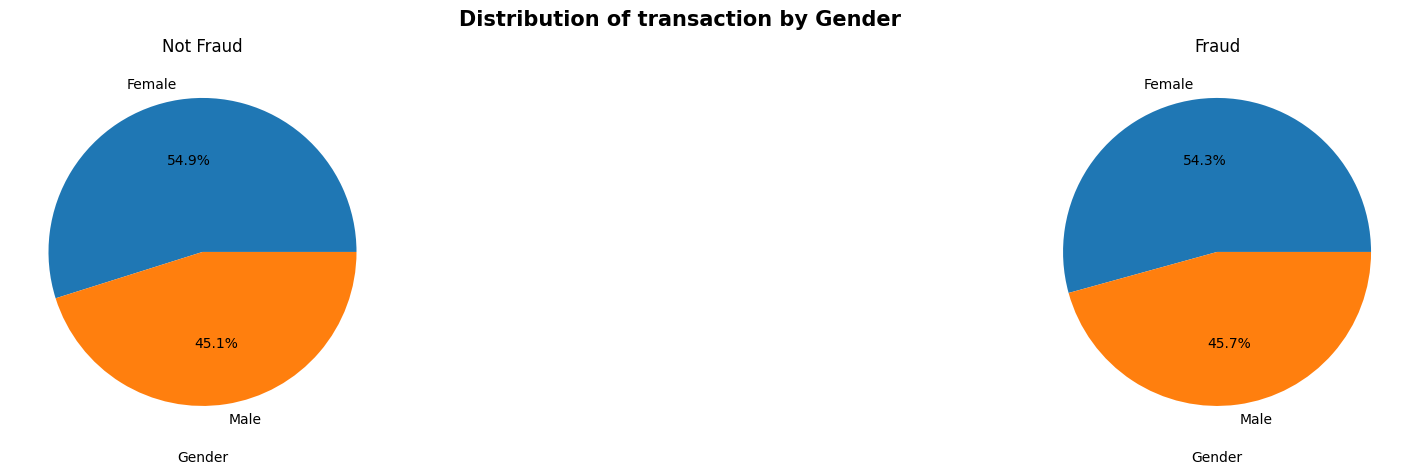

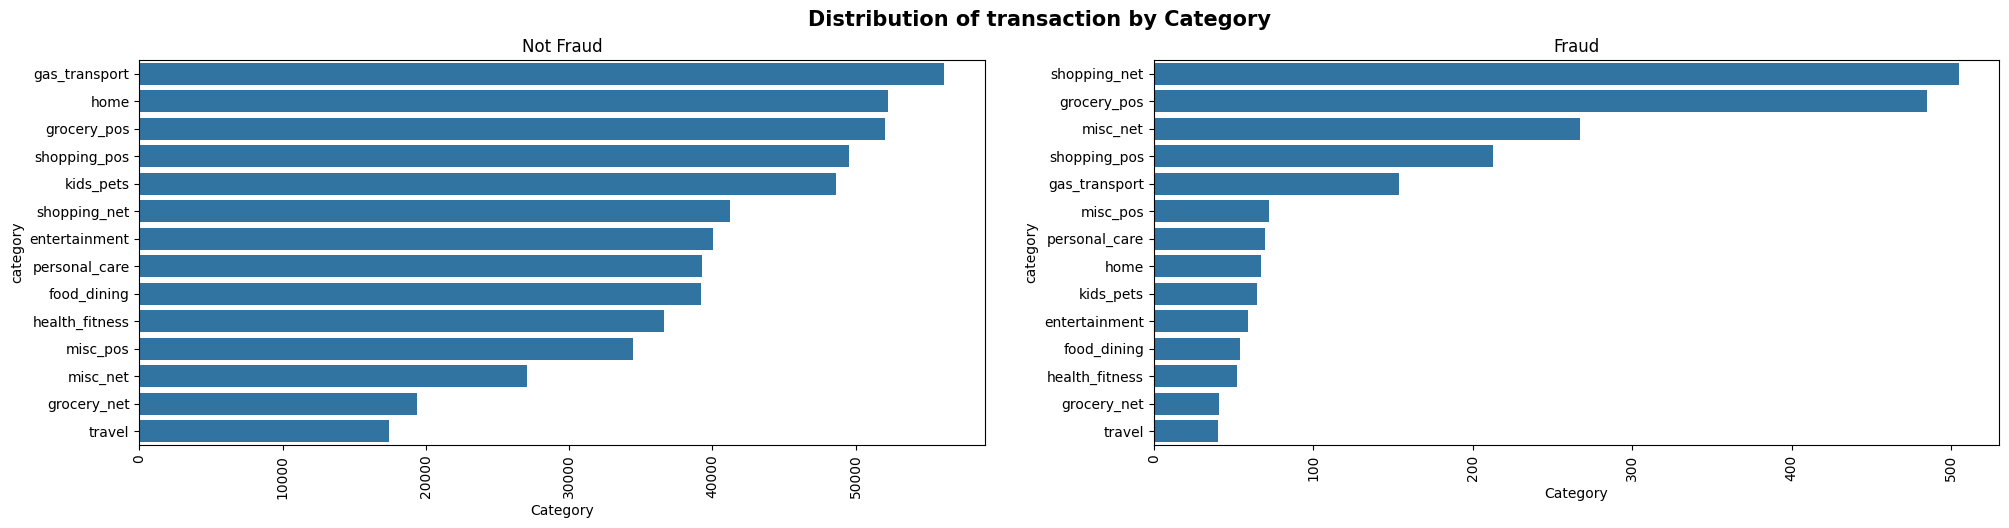

In [21]:
# Visualizing the distribution of transactions by gender and category

# Comparing fraud and non-fraud cases using pie charts and bar plots.

columns = ['gender', 'category']
columns_name = ['Gender', 'Category']
name = ['Not Fraud', 'Fraud']

df['fraud'] = df['is_fraud'].apply(lambda x: "Fraud" if x == 1 else 'Not Fraud')

index = 0
for col in columns:
    fig = plt.figure(figsize=(24, 5))
    plt.suptitle("Distribution of transaction by " + columns_name[index], fontsize=15, fontweight='bold')
    
    for i in range(2):
        plt.subplot(1, 2, i+1)
        df_1 = df[df['is_fraud'] == i]

        if col == 'gender':
            plt.pie(df_1[col].value_counts(), labels=['Female', 'Male'], autopct='%1.1f%%')
        elif col == 'category':
            ax = sns.countplot(data=df_1, y=col, order=df_1[col].value_counts().index)
            plt.xticks(rotation=90)
        
        plt.title(name[i])
        plt.xlabel(columns_name[index])

    index += 1
    plt.show()

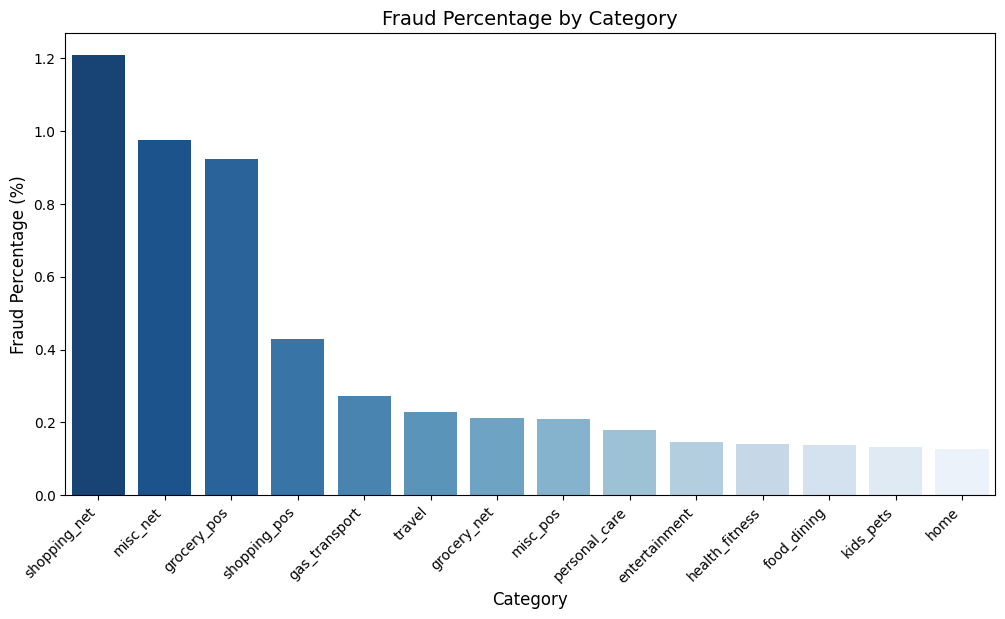

In [22]:
# Calculating and visualizing the percentage of fraudulent transactions 
# within each category using a bar plot.
category_fraud_counts = df[df["is_fraud"] == 1]["category"].value_counts()
category_total_counts = df["category"].value_counts()
fraud_percentage = (category_fraud_counts / category_total_counts * 100).dropna()

fraud_percentage = fraud_percentage.sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=fraud_percentage.index, y=fraud_percentage.values, palette="Blues_r")

plt.xlabel("Category", fontsize=12)
plt.ylabel("Fraud Percentage (%)", fontsize=12)
plt.title("Fraud Percentage by Category", fontsize=14)
plt.xticks(rotation=45, ha="right") 

plt.show()

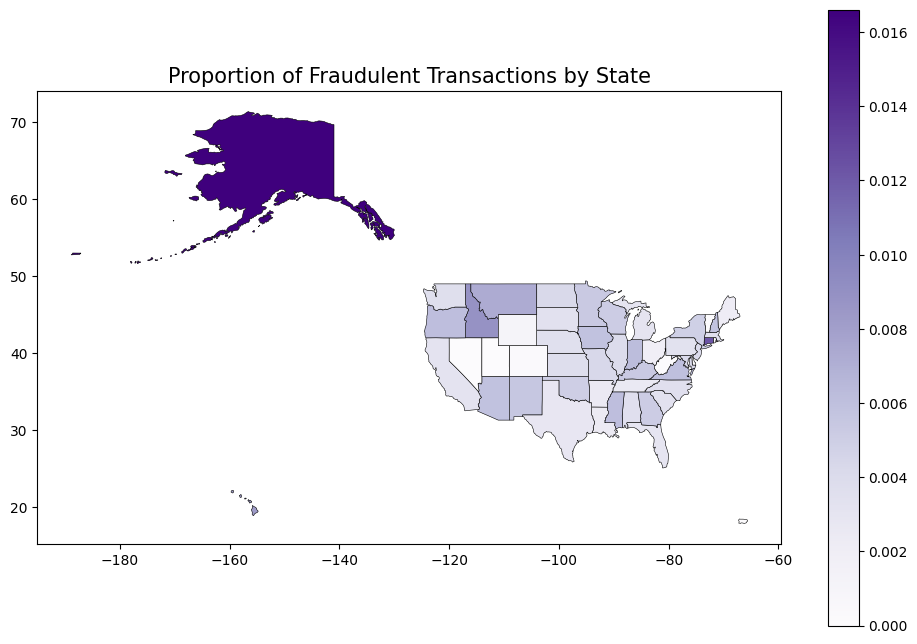

In [23]:
# Mapping the proportion of fraudulent transactions by state using a choropleth map

# Defining the URL for a GeoJSON file containing U.S. state boundaries
url = "https://github.com/PublicaMundi/MappingAPI/raw/master/data/geojson/us-states.json"
us_map = gpd.read_file(url)

# Creating a dictionary to map U.S. state abbreviations to their full names
us_state_abbrev = {
    "AL": "Alabama", "AK": "Alaska", "AZ": "Arizona", "AR": "Arkansas", "CA": "California",
    "CO": "Colorado", "CT": "Connecticut", "DE": "Delaware", "FL": "Florida", "GA": "Georgia",
    "HI": "Hawaii", "ID": "Idaho", "IL": "Illinois", "IN": "Indiana", "IA": "Iowa",
    "KS": "Kansas", "KY": "Kentucky", "LA": "Louisiana", "ME": "Maine", "MD": "Maryland",
    "MA": "Massachusetts", "MI": "Michigan", "MN": "Minnesota", "MS": "Mississippi", 
    "MO": "Missouri", "MT": "Montana", "NE": "Nebraska", "NV": "Nevada", "NH": "New Hampshire",
    "NJ": "New Jersey", "NM": "New Mexico", "NY": "New York", "NC": "North Carolina",
    "ND": "North Dakota", "OH": "Ohio", "OK": "Oklahoma", "OR": "Oregon", "PA": "Pennsylvania",
    "RI": "Rhode Island", "SC": "South Carolina", "SD": "South Dakota", "TN": "Tennessee",
    "TX": "Texas", "UT": "Utah", "VT": "Vermont", "VA": "Virginia", "WA": "Washington",
    "WV": "West Virginia", "WI": "Wisconsin", "WY": "Wyoming", "DC": "District of Columbia"
}

fraud_counts = df[df["is_fraud"] == 1]["state"].value_counts().reset_index()
fraud_counts.columns = ["state", "fraud_count"]

non_fraud_counts = df[df["is_fraud"] == 0]["state"].value_counts().reset_index()
non_fraud_counts.columns = ["state", "non_fraud_count"]

fraud_counts["state"] = fraud_counts["state"].map(us_state_abbrev)
non_fraud_counts["state"] = non_fraud_counts["state"].map(us_state_abbrev)

us_map["name"] = us_map["name"].str.title()

us_map = us_map.merge(fraud_counts, left_on="name", right_on="state", how="left")
us_map = us_map.merge(non_fraud_counts, left_on="name", right_on="state", how="left")

us_map["fraud_count"] = us_map["fraud_count"].fillna(0)
us_map["non_fraud_count"] = us_map["non_fraud_count"].fillna(0)

us_map["fraud_ratio"] = us_map["fraud_count"] / (us_map["fraud_count"] + us_map["non_fraud_count"])
us_map["fraud_ratio"] = us_map["fraud_ratio"].fillna(0)

fig, ax = plt.subplots(figsize=(12, 8))
us_map.plot(column="fraud_ratio", cmap="Purples", linewidth=0.4, edgecolor="black", legend=True, ax=ax)

ax.set_title("Proportion of Fraudulent Transactions by State", fontsize=15)

plt.show()

# Data Preprocessing and Feature Engineering

In [24]:
# Converting the transaction timestamp to a datetime format
df["trans_date_trans_time"] = pd.to_datetime(df["trans_date_trans_time"])
df["trans_date_trans_time"] = df["trans_date_trans_time"].dt.strftime("%d/%m/%Y %H:%M")

In [25]:
# Removing the "fraud_" prefix from merchant names
df['merchant'] = df['merchant'].str.replace("fraud_", "")
df[['trans_date', 'trans_time']] = df['trans_date_trans_time'].str.split(' ', expand=True)

In [26]:
# Extracting transaction hour, month, and day of the week for further analysis.
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'], dayfirst=True)
df['trans_date'] = pd.to_datetime(df['trans_date'], dayfirst=True)
df['trans_time'] = pd.to_datetime(df['trans_time'], format= '%H:%M').dt.time
df['trans_time_group'] = df['trans_date_trans_time'].dt.hour
df['trans_month'] = df['trans_date'].dt.to_period('M').astype("str")
df['trans_dayOfWeek'] = df['trans_date'].dt.day_name()

In [27]:
# Converting date of birth (dob) to datetime format and calculating age based on the year 2020
df['dob'] = pd.to_datetime(df['dob'], dayfirst=True)
df['age'] = 2020 - df['dob'].dt.year

In [28]:
# Displaying the unique age values present in the dataset
df['age'].unique()

array([52, 30, 50, 33, 65, 29, 69, 48, 47, 64, 24, 44, 43, 83, 49, 32, 28,
       23, 35, 63, 72, 90, 46, 56, 62, 25, 40, 51, 45, 59, 77, 41, 34, 26,
       91, 86, 27, 21, 38, 22, 36, 42, 31, 53, 20, 71, 82, 54, 55, 75, 37,
       16, 68, 39, 70, 17, 66, 60, 79, 58, 74, 67, 96, 57, 19, 61, 94, 73,
       84, 85, 81, 78, 15, 76, 89, 93, 80, 92, 87, 88, 18])

In [29]:
# Defining a function to categorize individuals into age groups
def apply_age_group(age):
    if age <= 18:
        return "Minors"
    elif age <= 25:
        return "Young Adults"
    elif age <= 45:
        return "Adults"
    elif age <= 60:
        return "Mature Adults"
    else:
        return "Seniors"

In [30]:
df['age_group'] = df['age'].apply(apply_age_group)

In [31]:
df['full_name'] = df['first'] + ' ' + df['last']

In [32]:
# Calculating time differences between consecutive transactions, 
# and categorizing them into predefined time windows.
# Since we think that the fraud transaction maybe happened frequently in short time, we decide to do this 

df['trans_datetime'] = pd.to_datetime(df['trans_date_trans_time'], format='%d/%m/%Y %H:%M')

df = df.sort_values(by=['cc_num', 'trans_datetime'])

df['time_diff'] = df.groupby('cc_num')['trans_datetime'].diff()

# Define the time windows
time_windows = [
    ('10 min', pd.Timedelta(minutes=10)),
    ('30 min', pd.Timedelta(minutes=30)),
    ('1 hour', pd.Timedelta(hours=1)),
    ('3 hours', pd.Timedelta(hours=3)),
    ('6 hours', pd.Timedelta(hours=6)),
    ('12 hours', pd.Timedelta(hours=12)),
    ('24 hours', pd.Timedelta(days=1)),
    ('2 days', pd.Timedelta(days=2)),
    ('5 days', pd.Timedelta(days=5)),
    ('10 days', pd.Timedelta(days=10)),
    ('30 days', pd.Timedelta(days=30)),
    ('3 months', pd.Timedelta(days=90)),
    ('6 months', pd.Timedelta(days=180))
]

def categorize_time_diff(diff):
    if pd.isna(diff):
        return 'None'
    for label, boundary in time_windows:
        if diff <= boundary:
            return label
    return '6 months+'

df['time_window'] = df['time_diff'].apply(categorize_time_diff)

In [33]:
df = df.sort_values(by='trans_id')

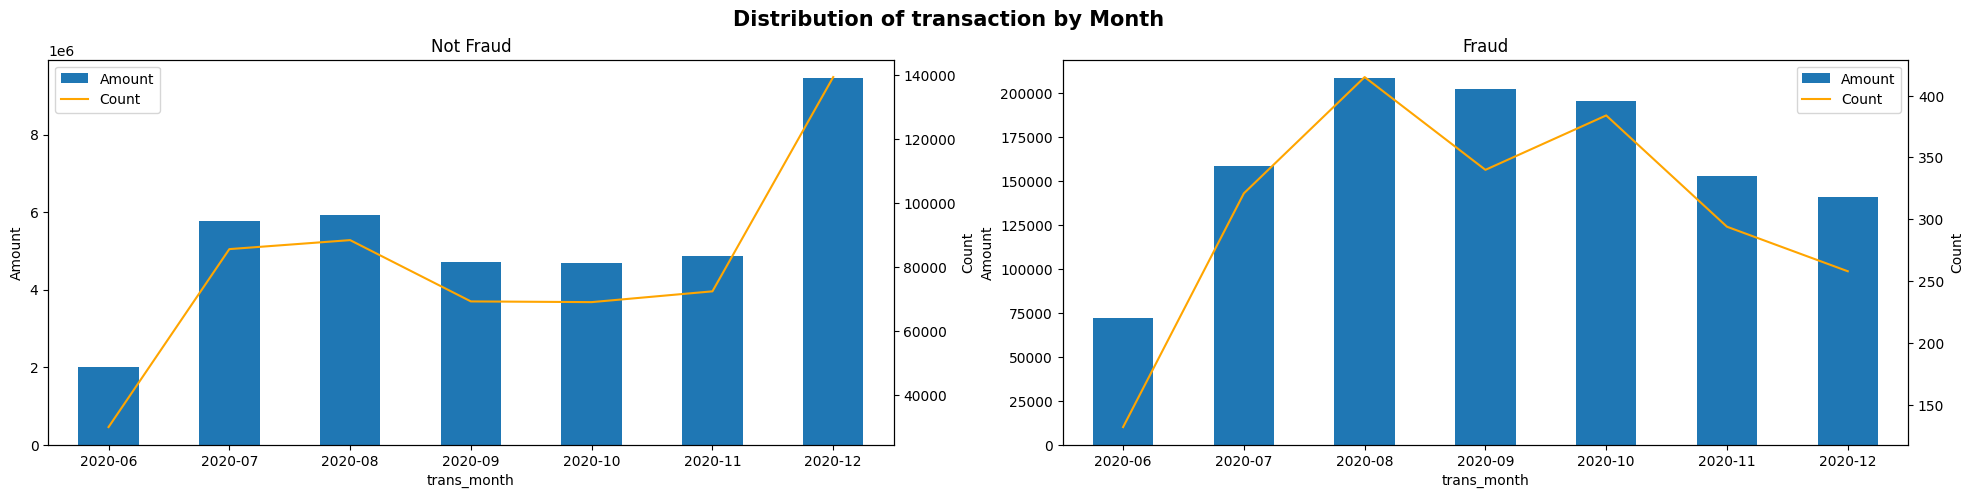

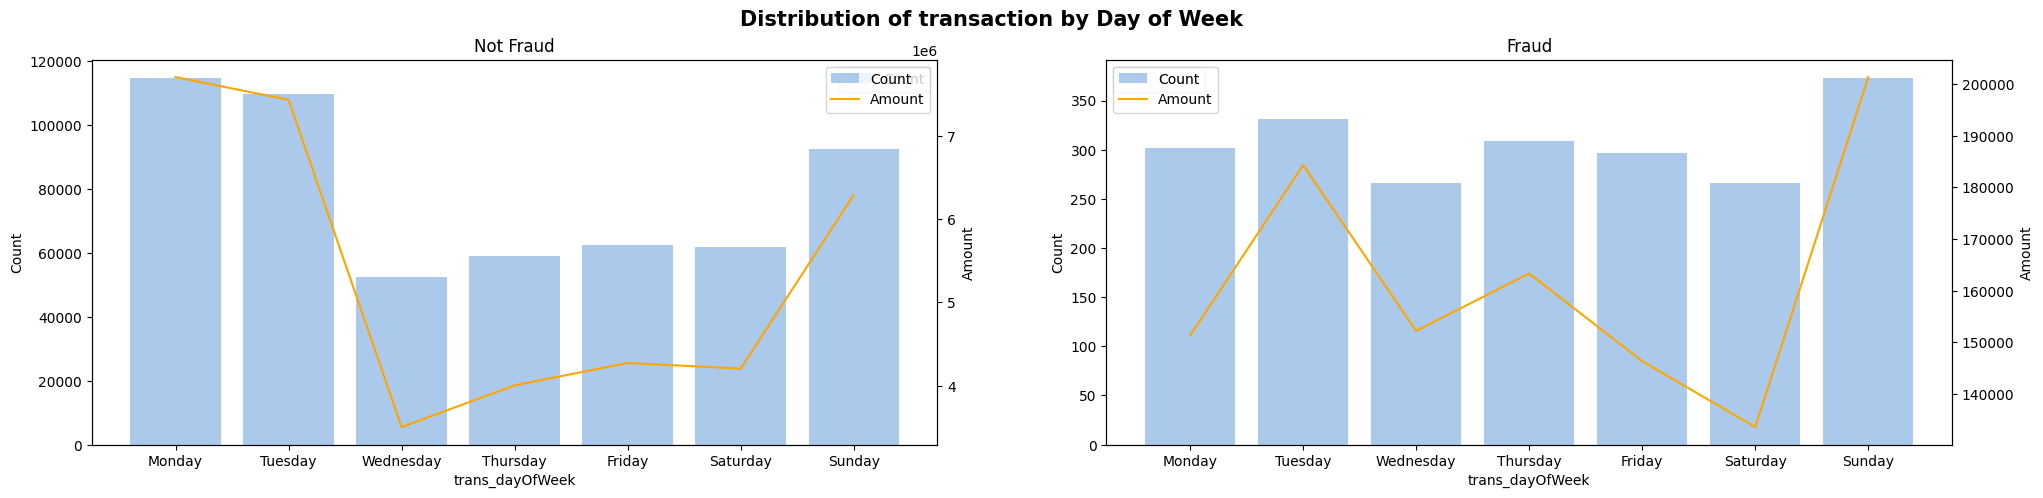

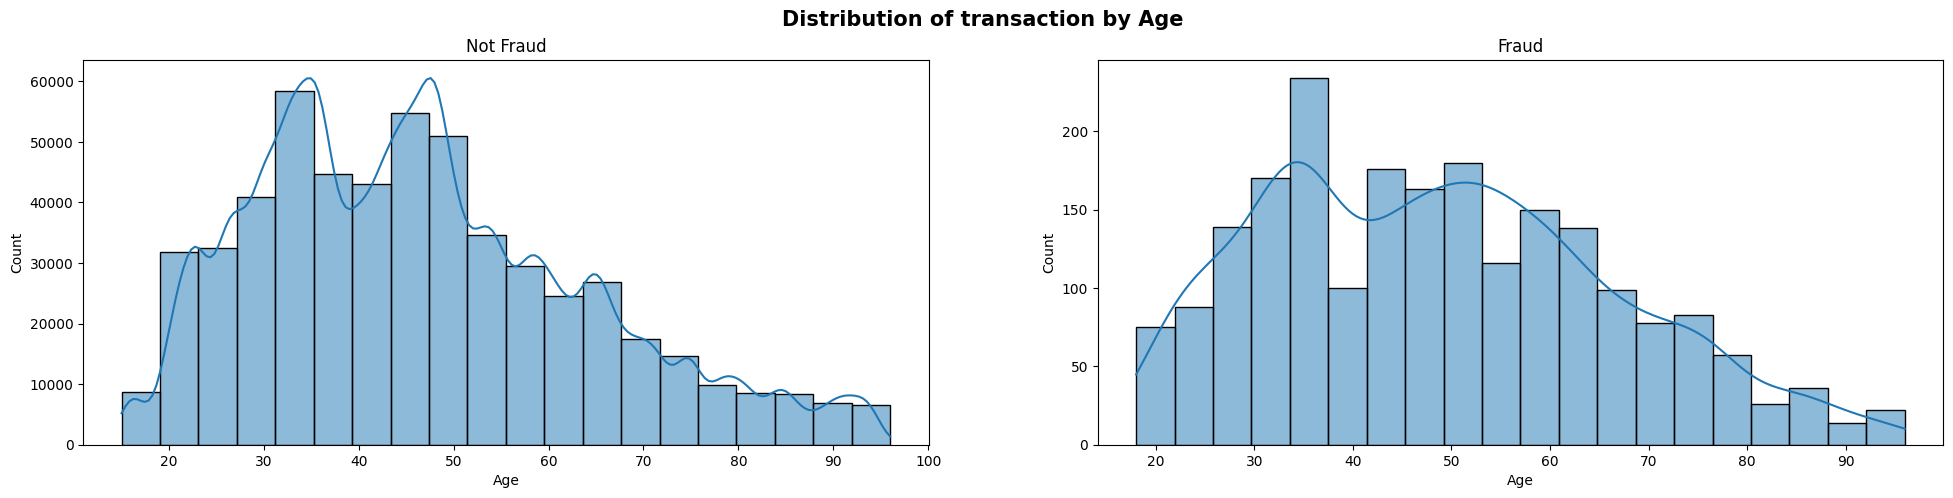

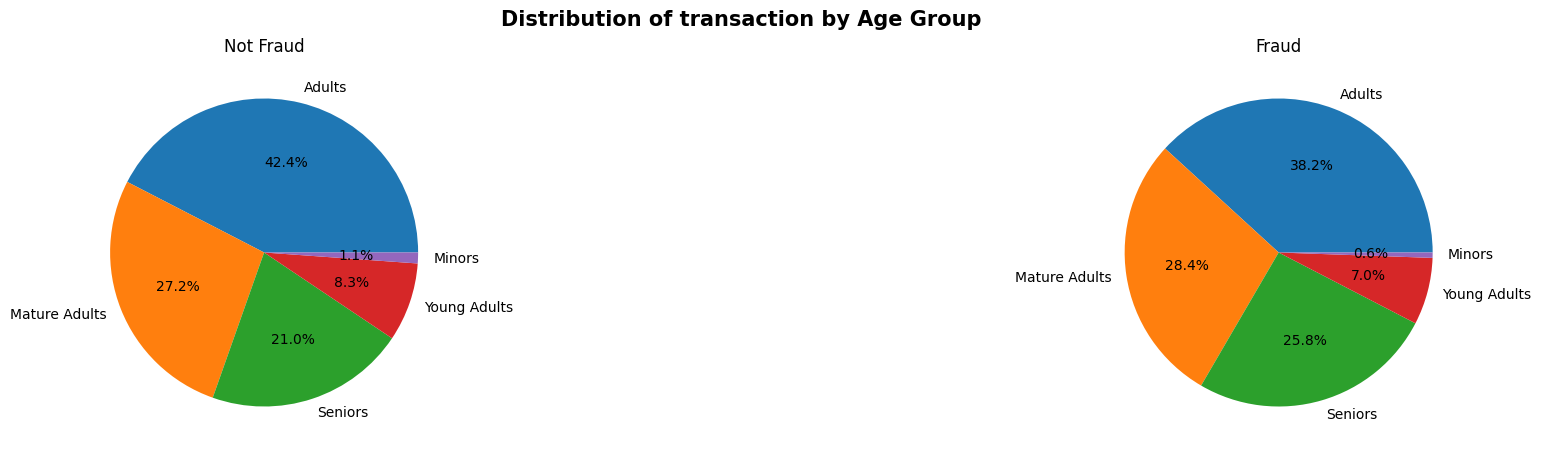

In [34]:
# Visualizing the distribution of transactions by month, day of the week, age, and age group
# Comparing fraud and non-fraud cases using bar plots, line plots, pie charts, and histograms.

columns = ['trans_month', 'trans_dayOfWeek', 'age', 'age_group']
columns_name = ['Month', 'Day of Week', 'Age', 'Age Group']
name = ['Not Fraud', 'Fraud']

df['fraud'] = df['is_fraud'].apply(lambda x: "Fraud" if x == 1 else 'Not Fraud')

index = 0
for col in columns:
    fig = plt.figure(figsize=(24, 5))
    plt.suptitle("Distribution of transaction by " + columns_name[index], fontsize=15, fontweight='bold')
    
    for i in range(2):
        plt.subplot(1, 2, i+1)
        df_1 = df[df['is_fraud'] == i]

        if col == 'trans_month':
            ax = df_1.groupby(col)['amt'].sum().plot(kind='bar', label='Amount')
            ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
            ax.set_ylabel('Amount')

            plt.twinx()
            ax1 = df_1.groupby(col).size().plot(kind='line', color='orange', label='Count')
            ax1.set_ylabel('Count')

            chart, labels = ax.get_legend_handles_labels()
            chart1, labels1 = ax1.get_legend_handles_labels()
            ax1.legend(chart + chart1, labels + labels1, loc=0)

        elif col == 'trans_dayOfWeek':
            cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
            ax = sns.barplot(data=df_1.groupby(col).size().reset_index(), x=col, y=0, label='Count',
                             color='#a1c9f4', order=cats)
            ax.set_ylabel('Count')

            plt.twinx()
            ax1 = sns.lineplot(data=df_1.groupby(col)['amt'].sum().reindex(cats).reset_index(),
                               x=col, y='amt', label='Amount', color='orange')
            ax1.set_ylabel('Amount')

            chart, labels = ax.get_legend_handles_labels()
            chart1, labels1 = ax1.get_legend_handles_labels()
            ax1.legend(chart + chart1, labels + labels1, loc=0)

        elif col == 'age_group':
            ax = plt.pie(df_1[col].value_counts(), labels=df_1[col].value_counts().index, autopct='%1.1f%%')

        else:  # col == 'age'
            ax = sns.histplot(data=df_1, x=col, bins=20, kde=True)
            plt.xlabel(columns_name[index])

        plt.title(name[i])

    index += 1
    plt.show()

In [35]:
# Dropping unnecessary columns and converting the transaction month to an integer for further analysis.
df.drop(columns=['zip', 'trans_num', 'unix_time', 'merch_lat', 'merch_long','first','last','dob','lat','long','trans_date', 'trans_date_trans_time', 'trans_time','age_group', 'trans_time_group','fraud','trans_id','full_name'],inplace=True)
df['trans_month'] = df['trans_month'].apply(lambda x: int(x.split('-')[1]))

In [36]:
# Shuffling the dataset, balancing fraud and non-fraud cases

df = df.sample(frac=1)

fraud_df = df.loc[df['is_fraud'] == 1]
non_fraud_df = df.loc[df['is_fraud'] == 0][:2144]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

new_df = normal_distributed_df.sample(frac=1, random_state=42)

Distribution of the Classes in the subsample dataset
is_fraud
1    0.5
0    0.5
Name: count, dtype: float64


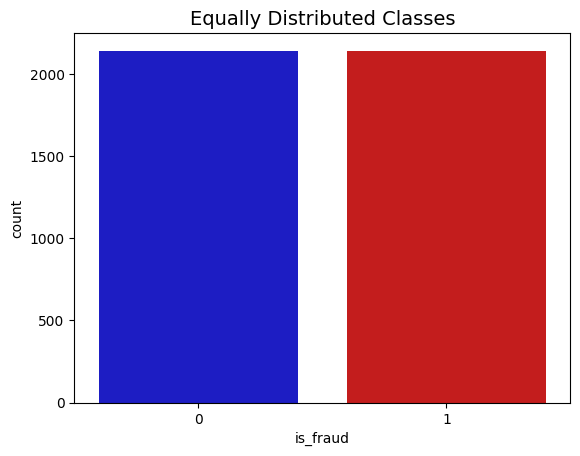

In [37]:
# Visualizing the balanced class distribution in the subsample dataset using a count plot

colors = ["#0101DF", "#DF0101"]

print('Distribution of the Classes in the subsample dataset')
print(new_df['is_fraud'].value_counts()/len(new_df))

sns.countplot(x='is_fraud', data=new_df, palette=colors)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

In [38]:
# Applying one-hot encoding to the 'gender' column, adding the encoded variables to the dataset
# Dropping the original column, and rearranging the column order with 'is_fraud' as the last column.
one_hot_encoded = pd.get_dummies(new_df['gender'], prefix='gender')

new_df = pd.concat([new_df, one_hot_encoded], axis=1)

new_df.drop(columns=['gender'], inplace=True)

cols = [col for col in new_df.columns if col != 'is_fraud'] + ['is_fraud']
new_df = new_df[cols]

In [39]:
# Encoding categorical variables using Target Encoding
# Replacing the original categorical columns with their encoded values
response_variable = 'is_fraud'

categorical_columns = [ 'job', 'state', 'street', 'merchant', 'city', 'category','trans_dayOfWeek', 'time_window']  

target_encoder = TargetEncoder(cols=categorical_columns)

target_encoder.fit(new_df[categorical_columns], new_df[response_variable])

df_encoded = target_encoder.transform(new_df[categorical_columns])

new_df.drop(columns=categorical_columns, inplace=True)
new_df = pd.concat([df_encoded ,new_df], axis=1)

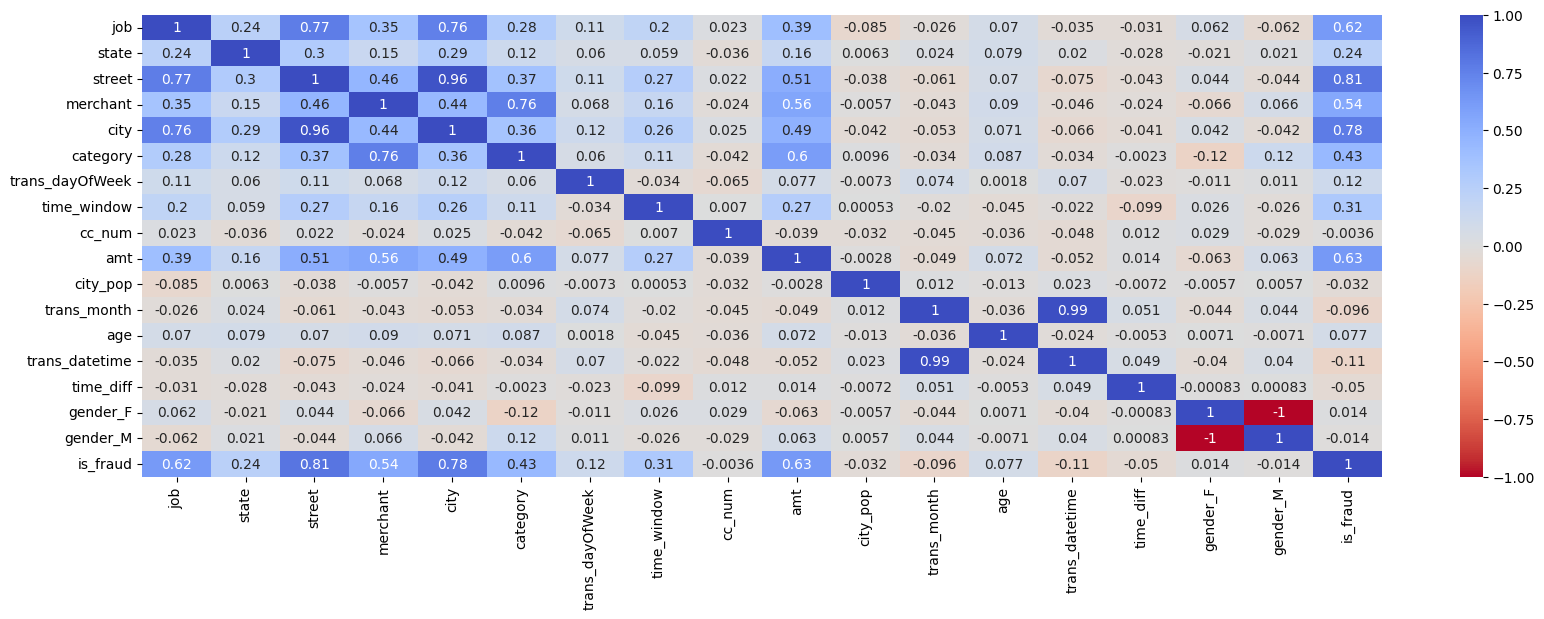

In [40]:
# Generating a heatmap to visualize the correlation between features in the dataset
# Identify relationships between variables
sub_sample_corr = new_df.corr()

plt.figure(figsize=(20,6))
sns.heatmap(sub_sample_corr,annot=True,cmap='coolwarm_r')
plt.show()

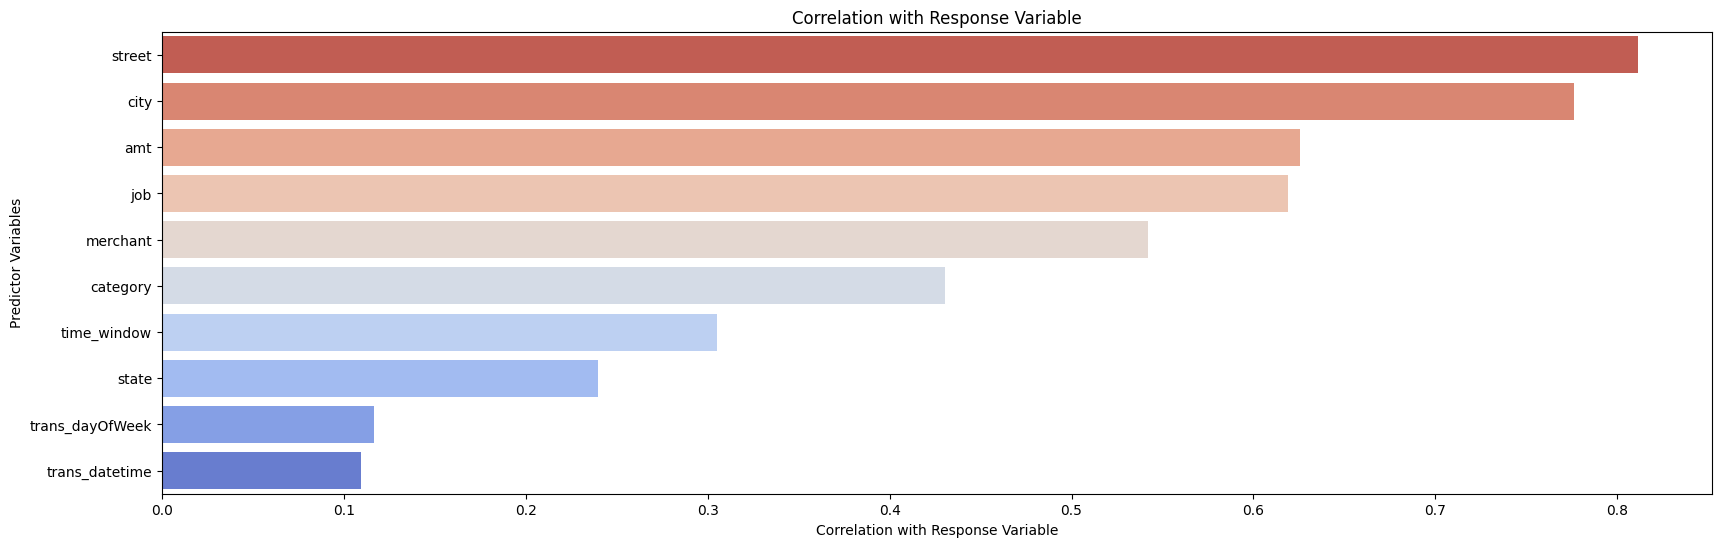

In [41]:
# Identifying and visualizing predictor variables with 
# a correlation above the threshold (0.1) with the fraud indicator.

correlation_with_response = new_df.corr()['is_fraud'].drop('is_fraud')
 
threshold = 0.1
relevant_correlations = correlation_with_response[abs(correlation_with_response) > threshold]

relevant_correlations = relevant_correlations.abs().sort_values(ascending=False)

plt.figure(figsize=(20, 6))
sns.barplot(x=relevant_correlations.values, y=relevant_correlations.index, palette='coolwarm_r')
plt.xlabel('Correlation with Response Variable')
plt.ylabel('Predictor Variables')
plt.title('Correlation with Response Variable')
plt.show()

In [42]:
# Selecting predictor variables with correlation above the threshold (0.1)
# Sorting them by absolute correlation strength in descending order for feature importance analysis.

relevant_variables = correlation_with_response[abs(correlation_with_response) > threshold].index.tolist()

relevant_variables.sort(key=lambda x: abs(correlation_with_response[x]), reverse=True)

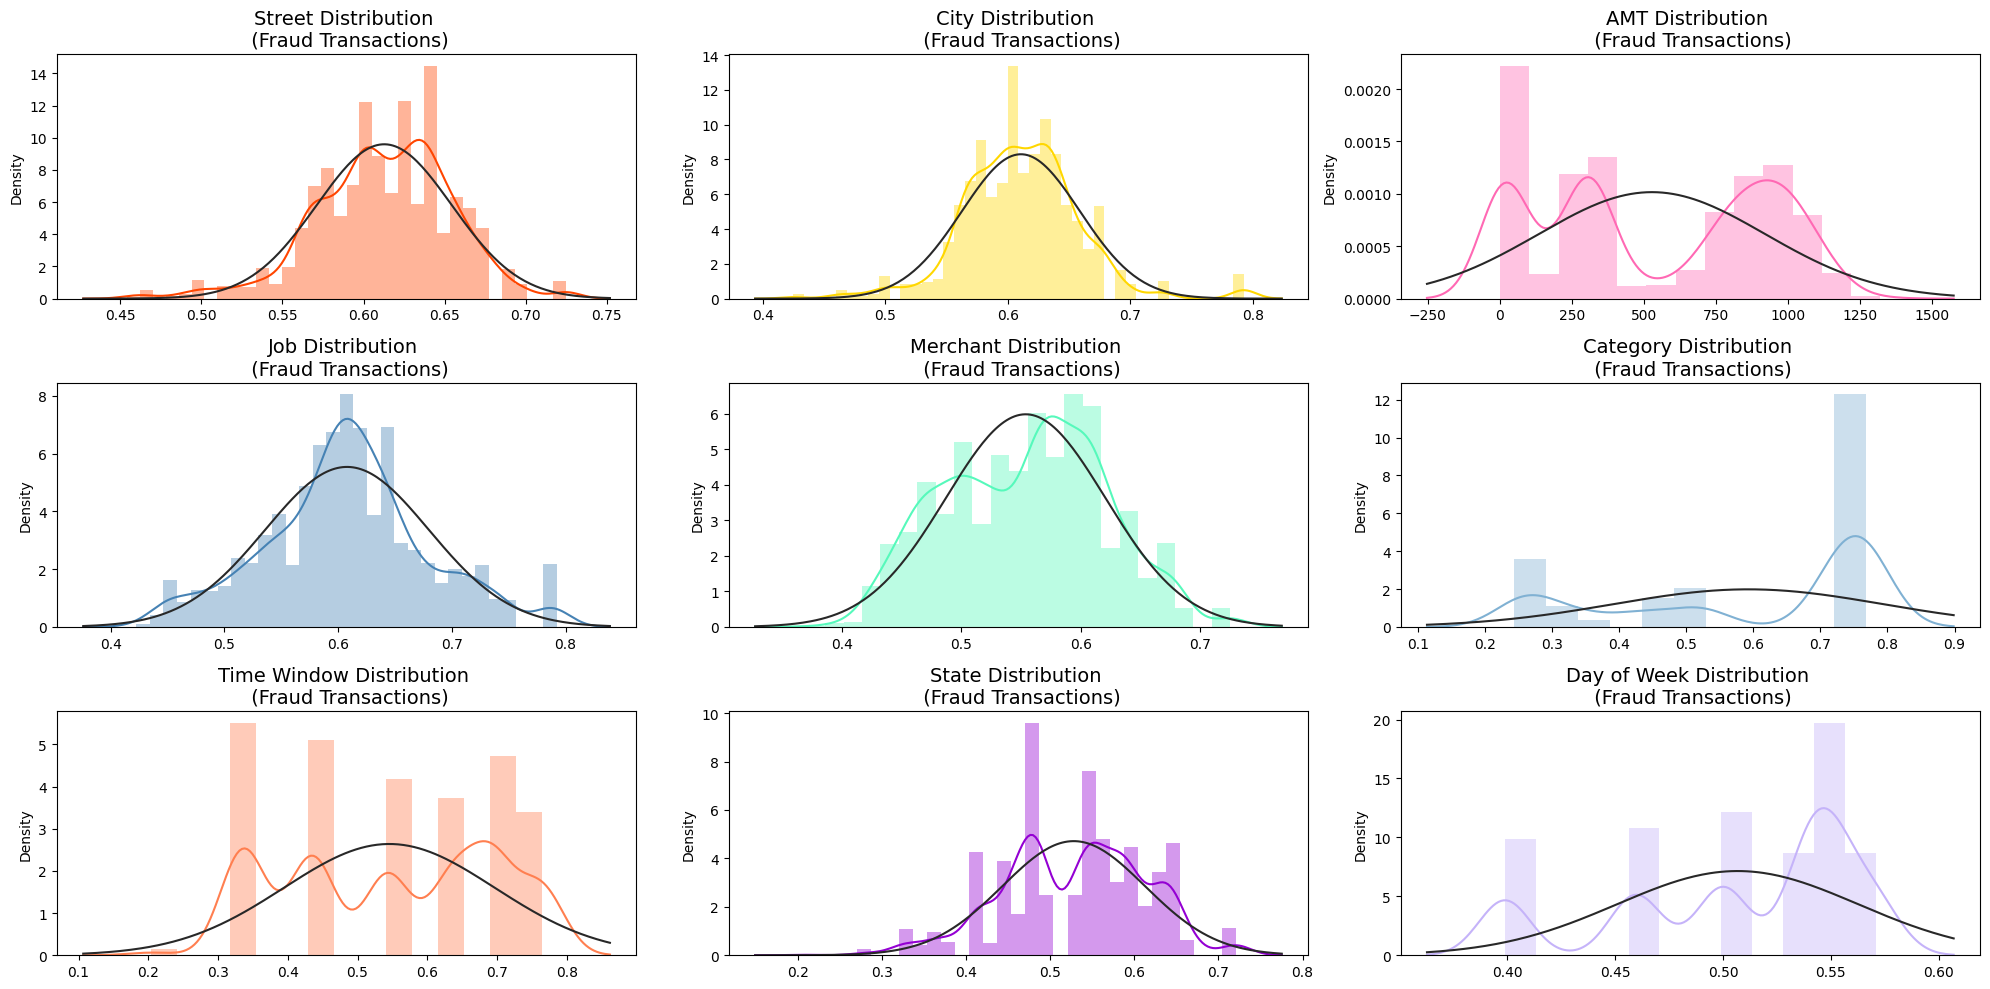

In [43]:
# Visualizing the distribution of various features for fraudulent transactions using histograms fitted with 
# a normal distribution across multiple subplots.
f, axes = plt.subplots(3, 3, figsize=(20, 10))

ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9 = axes.flatten()

street_fraud_dist = new_df['street'].loc[new_df['is_fraud'] == 1].values
sns.distplot(street_fraud_dist,ax=ax1, fit=norm, color='#FF4500')
ax1.set_title('Street Distribution \n (Fraud Transactions)', fontsize=14)

city_fraud_dist = new_df['city'].loc[new_df['is_fraud'] == 1].values
sns.distplot(city_fraud_dist,ax=ax2, fit=norm, color='#FFD700')
ax2.set_title('City Distribution \n (Fraud Transactions)', fontsize=14)

amt_fraud_dist = new_df['amt'].loc[new_df['is_fraud'] == 1].values
sns.distplot(amt_fraud_dist,ax=ax3, fit=norm, color='#FF69B4')
ax3.set_title('AMT Distribution \n (Fraud Transactions)', fontsize=14)

job_fraud_dist = new_df['job'].loc[new_df['is_fraud'] == 1].values
sns.distplot(job_fraud_dist,ax=ax4, fit=norm, color='#4682B4')
ax4.set_title('Job Distribution \n (Fraud Transactions)', fontsize=14)

merchant_fraud_dist = new_df['merchant'].loc[new_df['is_fraud'] == 1].values
sns.distplot(merchant_fraud_dist,ax=ax5, fit=norm, color='#56F9BB')
ax5.set_title('Merchant Distribution \n (Fraud Transactions)', fontsize=14)

category_fraud_dist = new_df['category'].loc[new_df['is_fraud'] == 1].values
sns.distplot(category_fraud_dist,ax=ax6, fit=norm, color='#80B1D3')
ax6.set_title('Category Distribution \n (Fraud Transactions)', fontsize=14)

time_window_fraud_dist = new_df['time_window'].loc[new_df['is_fraud'] == 1].values
sns.distplot(time_window_fraud_dist,ax=ax7, fit=norm, color='#FF7F50')
ax7.set_title('Time Window Distribution \n (Fraud Transactions)', fontsize=14)

state_fraud_dist = new_df['state'].loc[new_df['is_fraud'] == 1].values
sns.distplot(state_fraud_dist,ax=ax8, fit=norm, color='#9400D3')
ax8.set_title('State Distribution \n (Fraud Transactions)', fontsize=14)

trans_dayOfWeek_fraud_dist = new_df['trans_dayOfWeek'].loc[new_df['is_fraud'] == 1].values
sns.distplot(trans_dayOfWeek_fraud_dist,ax=ax9, fit=norm, color='#C5B3F9')
ax9.set_title('Day of Week Distribution \n (Fraud Transactions)', fontsize=14)

plt.tight_layout()
plt.show()

In [44]:
new_df.to_csv('filename.csv', index=False)

,job,state,street,merchant,city,category,trans_dayOfWeek,time_window,cc_num,amt,city_pop,trans_month,age,trans_datetime,time_diff,gender_F,gender_M,is_fraud
82112,0.721913,0.566366,0.640382,0.484702,0.640382,0.436261,0.398943,0.435432,4.428780e+18,7.28,95015,7,74,2020-07-20 00:57:00,0 days 01:02:00,False,True,1
400173,0.626551,0.596066,0.626551,0.518243,0.626551,0.436261,0.570815,0.435432,3.054650e+13,7.58,7430,11,65,2020-11-25 01:17:00,0 days 01:03:00,False,True,1
34075,0.416009,0.545171,0.416009,0.612648,0.416009,0.723881,0.543956,0.542950,3.409510e+14,202.93,5950,7,49,2020-07-03 01:39:00,0 days 19:26:00,True,False,0
134680,0.511426,0.630246,0.422767,0.422767,0.422767,0.279570,0.543956,0.204503,4.561890e+12,34.58,78968,8,52,2020-08-07 14:50:00,2 days 21:25:00,True,False,0
355743,0.551671,0.483051,0.422767,0.574836,0.422767,0.768645,0.543956,0.542950,5.018310e+11,4.77,1762,11,58,2020-11-06 02:24:00,0 days 19:11:00,False,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318937,0.463227,0.581350,0.401092,0.422767,0.401092,0.271357,0.459722,0.342858,3.514870e+15,56.33,899,10,53,2020-10-20 13:37:00,1 days 13:44:00,False,True,0
62141,0.518243,0.559054,0.577233,0.424069,0.577233,0.243636,0.500000,0.342858,6.763140e+11,260.44,9512,7,48,2020-07-12 23:46:00,1 days 06:49:00,True,False,1
67662,0.384262,0.450000,0.422767,0.401092,0.416009,0.269231,0.459722,0.435432,3.511380e+15,1.28,190178,7,47,2020-07-14 12:04:00,0 days 01:18:00,False,True,0
258098,0.200656,0.413919,0.375130,0.401092,0.365529,0.243636,0.570815,0.435432,5.038740e+11,32.03,1595797,9,45,2020-09-23 22:51:00,0 days 01:53:00,False,True,0
